In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cc-ar-300-bin-gz/cc.ar.300.bin
/kaggle/input/aner-corp/ANERCorp.xlsx


In [2]:
!pip install fasttext

In [3]:
!pip install torchinfo


In [4]:
!pip install openpyxl

In [5]:
!pip install pytorch-crf


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF
from sklearn.model_selection import train_test_split
import fasttext
import torch.nn.functional as F  # Add this import statement to your script
import re

# Load FastText model
ft = fasttext.load_model('/kaggle/input/cc-ar-300-bin-gz/cc.ar.300.bin')

# Load dataset
data = pd.read_excel('/kaggle/input/aner-corp/ANERCorp.xlsx', usecols=[0, 1], header=None, names=['Word', 'Tag'])

def preprocess_text(text):
    # Your existing preprocessing logic
    if not isinstance(text, str):
        return text
    # Normalize Arabic letters, remove diacritics, punctuation (except periods), and lowercase
    text = re.sub("[أإآ]", "ا", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("[\u064B-\u065F]", "", text)
    text = re.sub(r'[^.\w\s]', '', text)  # Retain periods for sentence splitting
    return text.lower()

data['Word'] = data['Word'].apply(preprocess_text)

# Adjust the method to identify sentence boundaries
# Here, ensure '.' is treated correctly as a sentence delimiter
data['IsPeriod'] = data['Word'] == '.'
data['Sentence#'] = data['IsPeriod'].cumsum()

# Remove rows where 'Word' is just a period, as their only role was to mark sentence boundaries
data = data[data['Word'] != '.']

# Now, group by 'Sentence#' to form sentences
sentences = data.groupby('Sentence#')['Word'].apply(list).tolist()
tags = data.groupby('Sentence#')['Tag'].apply(list).tolist()

# Build vocabularies
word_to_ix = {"<PAD>": 0, "<UNK>": 1}
for sentence in sentences:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
tag_to_ix = {"<PAD>": 0}
for tag_seq in tags:
    for tag in tag_seq:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word_to_ix), ft.get_dimension()))
for word, idx in word_to_ix.items():
    if word in ["<PAD>", "<UNK>"] or not isinstance(word, str):
        continue
    embedding_matrix[idx] = ft.get_word_vector(word)
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)


# Dataset class
class NERDataset(Dataset):
    def __init__(self, sentences, tags, word_to_ix, tag_to_ix):
        self.sentences = [[word_to_ix[word] for word in sentence] for sentence in sentences]
        self.tags = [[tag_to_ix[tag] for tag in tag_seq] for tag_seq in tags]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx], dtype=torch.long), torch.tensor(self.tags[idx], dtype=torch.long)

# Collate function for DataLoader
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=word_to_ix["<PAD>"])
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=tag_to_ix["<PAD>"])
    return xx_pad, yy_pad

# Split data and create DataLoader
X_train, X_test, Y_train, Y_test = train_test_split(sentences, tags, test_size=0.1)
train_data = NERDataset(X_train, Y_train, word_to_ix, tag_to_ix)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=pad_collate)

# Define the model
class NERModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, tagset_size, cnn_out_channels=64, kernel_size=3):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.cnn = nn.Conv1d(in_channels=embedding_matrix.size(1), out_channels=cnn_out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.lstm = nn.LSTM(cnn_out_channels, hidden_dim // 2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, x):
        embeds = self.embedding(x).permute(0, 2, 1)  # Change to (batch, channels, sequence length) for CNN
        cnn_out = F.relu(self.cnn(embeds)).permute(0, 2, 1)  # Apply CNN and then permute back
        lstm_out, _ = self.lstm(cnn_out)
        emissions = self.fc(lstm_out)
        return emissions

    def loss(self, x, y):
        emissions = self.forward(x)
        mask = (x != word_to_ix['<PAD>'])
        return -self.crf(emissions, y, mask=mask)

# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NERModel(embedding_matrix.to(device), 256, len(tag_to_ix)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
for layer in model.children():
    print(layer)


Embedding(30929, 300)
Conv1d(300, 64, kernel_size=(3,), stride=(1,), padding=(1,))
LSTM(64, 128, batch_first=True, bidirectional=True)
Linear(in_features=256, out_features=26, bias=True)
CRF(num_tags=26)


In [8]:
from torchinfo import summary

# You need to specify input size (including batch size)
# For example, if your input tensor is of shape (batch_size, sequence_length),
# and assuming sequence_length is 100:
input_size = (32, 100)  # Example input size, adjust based on your actual data

# The model needs to be on the device expected for input tensors
model.to(device)

# Get the summary
summary(model, input_size=input_size, dtypes=[torch.long], device=device)


Layer (type:depth-idx)                   Output Shape              Param #
NERModel                                 [32, 100, 26]             728
├─Embedding: 1-1                         [32, 100, 300]            (9,278,700)
├─Conv1d: 1-2                            [32, 64, 100]             57,664
├─LSTM: 1-3                              [32, 100, 256]            198,656
├─Linear: 1-4                            [32, 100, 26]             6,682
Total params: 9,542,430
Trainable params: 263,730
Non-trainable params: 9,278,700
Total mult-adds (G): 1.12
Input size (MB): 0.03
Forward/backward pass size (MB): 16.54
Params size (MB): 38.17
Estimated Total Size (MB): 54.73

In [9]:
def evaluate(model, data_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct_predictions, total_predictions = 0, 0

    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            loss = model.loss(sentences, tags)
            total_loss += loss.item()

            # Decode the most likely tag sequences with CRF
            outputs = model(sentences)
            predicted_tags = model.crf.decode(outputs)

            # Flatten both true and predicted tags for accuracy calculation
            for i in range(len(tags)):
                true_tags = tags[i].cpu().numpy()
                mask = true_tags != tag_to_ix['<PAD>']  # Ignore PAD tokens
                correct_predictions += np.sum(true_tags[mask] == np.array(predicted_tags[i])[mask])
                total_predictions += np.sum(mask)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return total_loss / len(data_loader), accuracy


In [10]:
import torch
from tqdm import tqdm 

num_epochs = 10  # Number of epochs to train for

# Move model to the appropriate device
model.to(device)
# Split training data for validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)
train_data = NERDataset(X_train, Y_train, word_to_ix, tag_to_ix)
val_data = NERDataset(X_val, Y_val, word_to_ix, tag_to_ix)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=pad_collate)

training_losses = []
validation_losses = []
validation_accuracy = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for sentences, tags in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        sentences, tags = sentences.to(device), tags.to(device)
        optimizer.zero_grad()
        loss = model.loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    training_losses.append(total_loss / len(train_loader))
    val_loss, val_acc = evaluate(model, val_loader)  # Evaluate on validation set
    validation_losses.append(val_loss)
    validation_accuracy.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_losses[-1]}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc * 100:.2f}%')


Epoch 1/10: 100%|██████████| 121/121 [00:14<00:00,  8.21it/s]
/opt/conda/lib/python3.10/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Epoch 1/10, Training Loss: 845.6677644587745, Validation Loss: 582.8294001988003, Validation Accuracy: 87.40%


Epoch 2/10: 100%|██████████| 121/121 [00:14<00:00,  8.55it/s]


Epoch 2/10, Training Loss: 437.0442642968548, Validation Loss: 388.45620509556363, Validation Accuracy: 90.28%


Epoch 3/10: 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


Epoch 3/10, Training Loss: 314.34219499067825, Validation Loss: 311.4832109723772, Validation Accuracy: 91.98%


Epoch 4/10: 100%|██████████| 121/121 [00:14<00:00,  8.56it/s]


Epoch 4/10, Training Loss: 249.0179225196523, Validation Loss: 248.461177280971, Validation Accuracy: 93.78%


Epoch 5/10: 100%|██████████| 121/121 [00:14<00:00,  8.55it/s]


Epoch 5/10, Training Loss: 203.8842168760694, Validation Loss: 217.5432412283761, Validation Accuracy: 94.29%


Epoch 6/10: 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


Epoch 6/10, Training Loss: 176.43297885863248, Validation Loss: 199.11297825404577, Validation Accuracy: 94.42%


Epoch 7/10: 100%|██████████| 121/121 [00:13<00:00,  8.79it/s]


Epoch 7/10, Training Loss: 157.39002473689308, Validation Loss: 187.72836085728235, Validation Accuracy: 94.61%


Epoch 8/10: 100%|██████████| 121/121 [00:13<00:00,  8.64it/s]


Epoch 8/10, Training Loss: 141.02446753131457, Validation Loss: 178.17286954607283, Validation Accuracy: 94.66%


Epoch 9/10: 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


Epoch 9/10, Training Loss: 130.10479165699857, Validation Loss: 171.15813555036272, Validation Accuracy: 94.73%


Epoch 10/10: 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


Epoch 10/10, Training Loss: 119.91520936824074, Validation Loss: 165.36518369402205, Validation Accuracy: 94.93%


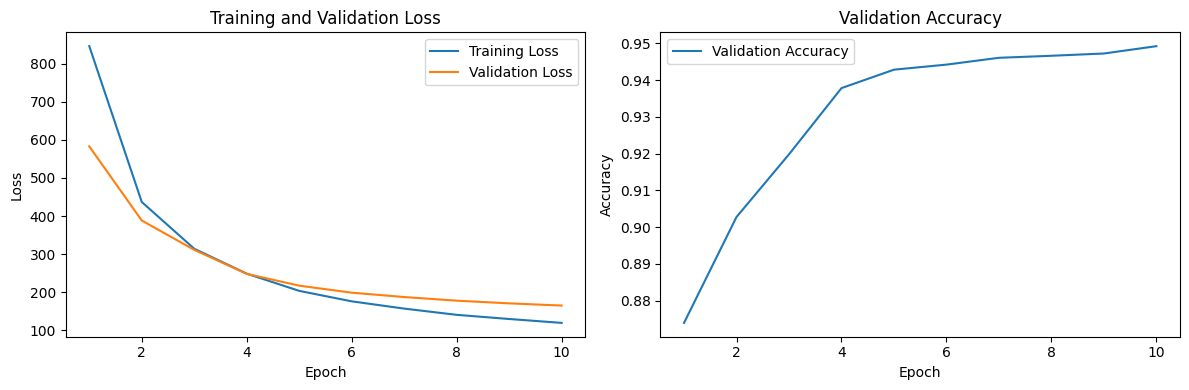

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def evaluate(model, data_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_true_tags = []
    all_predicted_tags = []

    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            loss = model.loss(sentences, tags)
            total_loss += loss.item()

            # Decode the most likely tag sequences with CRF
            outputs = model(sentences)
            predicted_tags = model.crf.decode(outputs)

            # Flatten both true and predicted tags for detailed metrics calculation
            for i in range(len(tags)):
                true_tags = tags[i].cpu().numpy()
                mask = true_tags != tag_to_ix['<PAD>']  # Ignore PAD tokens
                all_true_tags.extend(true_tags[mask])
                all_predicted_tags.extend(np.array(predicted_tags[i])[mask])

    # Calculate precision, recall, and F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_tags, all_predicted_tags, average='macro')

    accuracy = np.mean(np.array(all_true_tags) == np.array(all_predicted_tags))
    return total_loss / len(data_loader), accuracy, precision, recall, f1_score


# Example of how to call this function and print metrics
loss, accuracy, precision, recall, f1 = evaluate(model, val_loader)
print(f'Validation Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Validation Accuracy: 0.9493, Precision: 0.5178, Recall: 0.3894, F1 Score: 0.4187


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_and_report(model, data_loader, tag_to_ix):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_true_tags = []
    all_pred_tags = []

    with torch.no_grad():
        for sentences, tags in data_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            loss = model.loss(sentences, tags)
            total_loss += loss.item()

            # Decode the most likely tag sequences with CRF
            outputs = model(sentences)
            predicted_tags = model.crf.decode(outputs)

            # Collect true and predicted tags
            for i in range(len(tags)):
                true_tags = tags[i].cpu().numpy()
                mask = true_tags != tag_to_ix['<PAD>']  # Ignore PAD tokens
                all_true_tags.extend(true_tags[mask])
                all_pred_tags.extend(np.array(predicted_tags[i])[mask])

    # Calculate accuracy
    correct_predictions = np.sum(np.array(all_true_tags) == np.array(all_pred_tags))
    total_predictions = len(all_true_tags)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    # Convert indices to tag names (assuming you have an ix_to_tag dictionary)
    ix_to_tag = {ix: tag for tag, ix in tag_to_ix.items()}
    all_true_tags = [ix_to_tag[ix] for ix in all_true_tags]
    all_pred_tags = [ix_to_tag[ix] for ix in all_pred_tags]

    # Generate classification report
    print(classification_report(all_true_tags, all_pred_tags))

    return total_loss / len(data_loader), accuracy


# Example usage after your training loop
val_loss, val_acc = evaluate_and_report(model, val_loader, tag_to_ix)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc * 100:.2f}%')


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ERS       0.00      0.00      0.00         1
       B-LOC       0.91      0.86      0.88       455
      B-MISC       0.76      0.30      0.43        98
      B-MSIC       0.00      0.00      0.00         1
       B-ORF       0.00      0.00      0.00         1
       B-ORG       0.71      0.59      0.64       223
      B-PERS       0.83      0.75      0.79       346
       I-LOC       0.76      0.60      0.67        58
      I-MISC       0.70      0.09      0.16        76
       I-ORG       0.61      0.71      0.66       136
      I-PERS       0.89      0.80      0.85       291
           O       0.96      0.99      0.98     12709
         nan       0.63      0.13      0.22       145
           o       0.00      0.00      0.00         1
    فيرسلاين       0.00      0.00      0.00         1

    accuracy                           0.95     14542
   macro avg       0.52      0.39      0.42     14542
weighted avg       0.94   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
